# P2 Feature Detection, Feature Matching and Image Warping

[The instructions are the same as last time. See P1 for instructions.]

## P2.1 Harris Corners

Now that you've learned about Harris Corners, you're going to implement this procedure. For this question, **you should (1) use the `light_cubes_base.png` and also (2) another image of your choosing**. The procedure for the Harris corner detection: 

1. Compute the gradient at each point in the image
2. Compute the H matrix (or at least the elements of it) from the elements of the gradient (and a "smoothing" operation applied via a convolution with the weight matrix W)
3. Compute the scoring function (perhaps by computing the eigenvalues)
4. Find points with a large response (threshold f)
5. Find local maxima of f after thresholding (you will need to pick what you think is a "reasonable" threshold)

Where the Harris matrix $H$ is defined by
$$ H = \begin{bmatrix} A & B \\ B & C \end{bmatrix} = \sum_{(x, y) \in W} w_{x, y} \begin{bmatrix}
I_x^2 & I_x I_y \\ I_x I_y & I_y^2
\end{bmatrix} $$
and $I_x$ is the $x$-derivative of the image $I$, $I_y$ is the $y$-derivative of the image $I$ and $w$ is a weight matrix. Use the Sobel filters to compute the image derivatives. Use a convolution with the specified "weight matrix" W to compute the elements of the H matrix from the elements of the gradient multiplied together. You can use either definition of $f$ we introduced in class:

$$ f = \text{min}(\lambda_1, \lambda_2) $$
$$ f = \frac{\text{det}(H)}{\text{tr}(H)} $$

I have provided you with a local-maxima-finding function for you to use.

**Note that you should be completing this solution without using a Harris Corner detector package: you should be computing the image derivatives and the Harris corners themselves yourself using filters you implement, applied using the `scipy` convolution functions.** Using external packages to check your solutions is acceptable, but your answer will no doubt be slightly different than those packages.

### P2.1.1 Computing Harris Corners

**PLOTS: Generate a figure (a 2x2 image grid) that shows the following intermediate steps** during the computation of Harris Corners on the provided:
1. The x-derivative of the image, computed via the Sobel filter.
2. The "A" element of the H matrix for the whole image. To compute this, use the Sobel filter to compute the x-derivative and use a 5x5 mean filter (for the choice of weight matrix) to apply the effect of the window averaging (after squaring the x-derivative).
3. The scoring function $f$
4. The original image with dots showing the location of the detected corners. (Be sure to choose a *reasonable* threshold; you should expect to end up with on the order of a few dozen features. If you have thousands of features, your threshold is too low. If you have only one or two features, your threshold is too high.

For this first part, you should use a *uniform weight matrix of size 5x5* (`weights = np.ones((5, 5))/25`) when computing the scoring function. We will change this in the next part of the question. 


*Note: As you evaluate, you may get some "divide by zero" errors. Those are fairly normal, since there will be places when evaluating the score function "f" where the denominator will be zero. You can ignore those if you like, since the presence of NaN values will not impact the maximum finding function.*

*Note: Feel free to change the value of `threshold` if you like. You can tweak the parameters until you get "good looking" features.*

**QUESTION A:** (3 sentences) Are there any features in the Light Cubes image that you are surprised are *not* present? Highlight or discuss in words one or two regions of one of your images where features were detected that you did not expect or one or two regions you thought features might exist but do not. 

In class, we derived the Harris matrix and a special scoring function related to the eigenvalues of that matrix so that we could measure the *cornerness* of the image. 

**PLOTS:** Show what happens if you used a scoring function $f = \text{tr}(H) = A + C$ (the trace of the H matrix)? Plot this alternative scoring function for the `light_cubes_base` image and plot the detected features computed using it.

**QUESTION B:**
(2-4 sentences) What does this modified scoring function $\text{tr}(H)$ detect?  If we want to detect corners, why might we not want to use this scoring function? 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal
import scipy.ndimage
import scipy.ndimage.filters as filters

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

def get_local_maxima(data, threshold, do_return_values=False):
    # See: https://stackoverflow.com/a/9113227/3672986
    neighborhood_size = 3

    data_region_max = scipy.ndimage.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = scipy.ndimage.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y, r = [], [], []
    for dy, dx in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(round((dy.start + dy.stop - 1)/2))   
        y.append(y_center)
        r.append(data[y_center, x_center])
        
    if do_return_values:
        return np.array(list(zip(x, y))), r
    else:
        return np.array(list(zip(x, y,)))

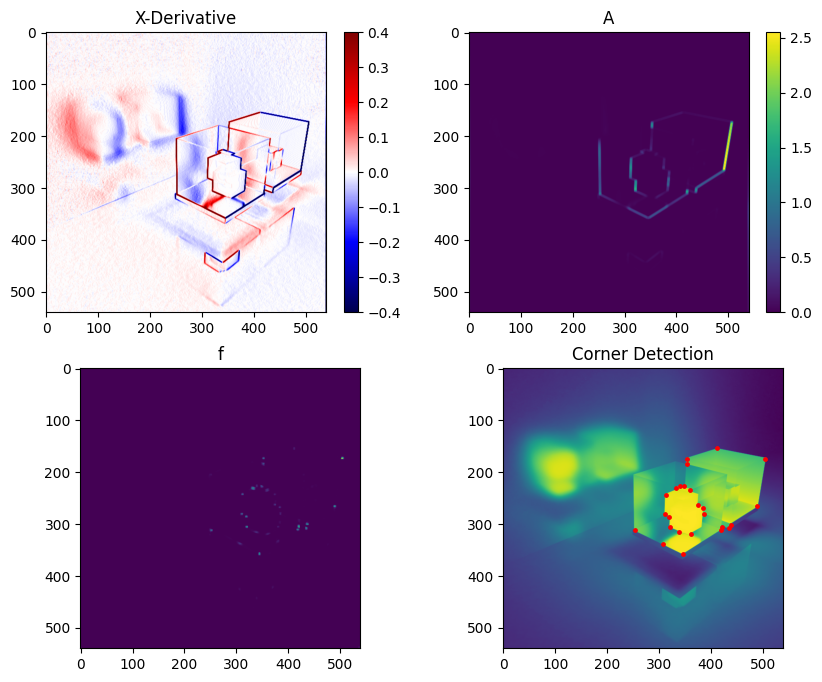

In [7]:
image = load_image("light_cubes_sm.png")[:, :, 0]

#Horizontal Sobel Filter:
hf = [
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]
#Vertical Sobel Filter:
vf = [
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]

weight = np.ones((5, 5))/25

Ix = scipy.signal.convolve(
          image, hf, mode='same')
Iy = scipy.signal.convolve(
          image, vf, mode='same')
A = scipy.signal.convolve(Ix**2, weight, mode='same')
B = scipy.signal.convolve(Ix * Iy, weight, mode='same')
C = scipy.signal.convolve(Iy**2, weight, mode='same')

H = [A, B, B, C]

# f = (H[0]*H[3]-H[1]**2) / (H[0]+H[3])
f = (A*C-B**2) / (A+C+1E-30)
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2 , 1)
plt.imshow(Ix, cmap='seismic', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title("X-Derivative")
plt.subplot(2, 2 , 2)
plt.imshow(A)
plt.colorbar()
plt.title("A")
plt.subplot(2, 2 , 3)
plt.imshow(f)
plt.title("f")
plt.subplot(2, 2 , 4)
plt.imshow(image)
plt.title("Corner Detection")

points = get_local_maxima(f, 0.054)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)

plt.show()




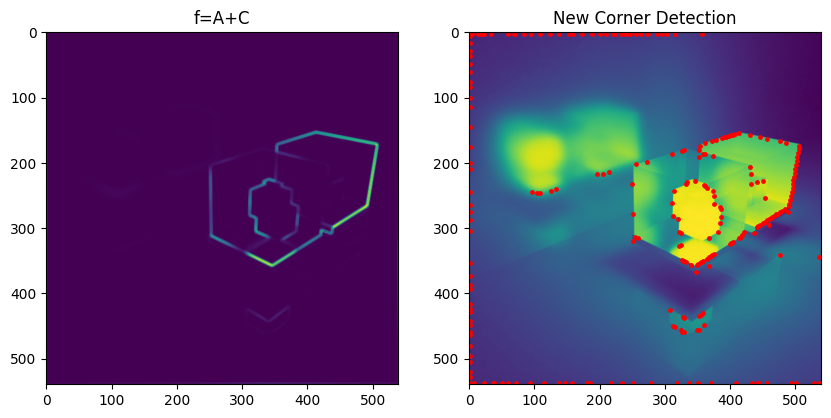

In [8]:
f = A+C
fig = plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.imshow(f)
plt.title("f=A+C")
plt.subplot(1, 2 , 2)
plt.imshow(image)

points = get_local_maxima(f, 0.034)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)
plt.title("New Corner Detection")
plt.show()

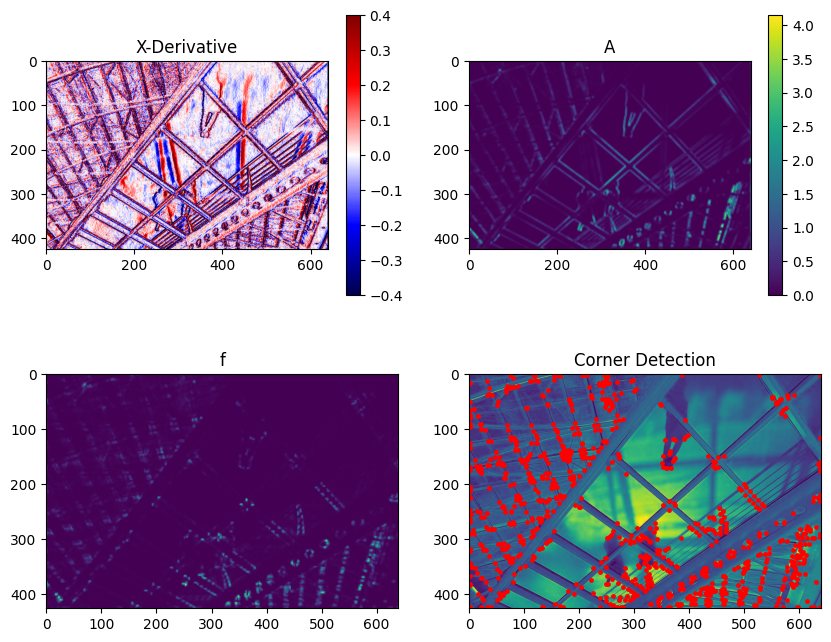

In [9]:
image = load_image("corner detection image.jpg")[:, :, 0]

Ix = scipy.signal.convolve(
          image, hf, mode='same')
Iy = scipy.signal.convolve(
          image, vf, mode='same')
A = scipy.signal.convolve(Ix**2, weight, mode='same')
B = scipy.signal.convolve(Ix * Iy, weight, mode='same')
C = scipy.signal.convolve(Iy**2, weight, mode='same')

H = [A, B, B, C]

# f = (H[0]*H[3]-H[1]**2) / (H[0]+H[3])
f = (A*C-B**2) / (A+C+1E-30)
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2 , 1)
plt.imshow(Ix, cmap='seismic', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title("X-Derivative")
plt.subplot(2, 2 , 2)
plt.imshow(A)
plt.colorbar()
plt.title("A")
plt.subplot(2, 2 , 3)
plt.imshow(f)
plt.title("f")
plt.subplot(2, 2 , 4)
plt.imshow(image)
plt.title("Corner Detection")

points = get_local_maxima(f, 0.05)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)



plt.show()



### P2.1.2 Varying the Weight Matrix

In this part, we will see what happens when we use different weight matrices.

**PLOTS** Using only the `light_cubes_base` image, plot the score function $f$ (one of the ones we discussed in class) and the detected corners for each of the following weight functions:

1. A uniform weight matrix of size 5x5 `weights = np.ones((5, 5))/(5**2)` (same as in the previous question).
2. A Gaussian weight matrix with $\sigma = 5$ (and size 25x25). (You can use the implementation of the Gaussian filter I provided you below.)
3. A uniform weight matrix of size 49x49 `weights = np.ones((49, 49))/(49**2)`

**QUESTION A:**
(3-5 sentences) Discuss the differences between these three weight functions. In particular, how do the features change for the third kernel, which is significantly 'wider' than the others?

**QUESTION B:**
(2 sentences) What happens to the score function if we were to use a 1x1 weight matrix $w = [1]$? Does this make sense? (Hint: think back to how we have defined and measure "cornerness"? Does it make sense to determine cornerness with a 1x1 window?)


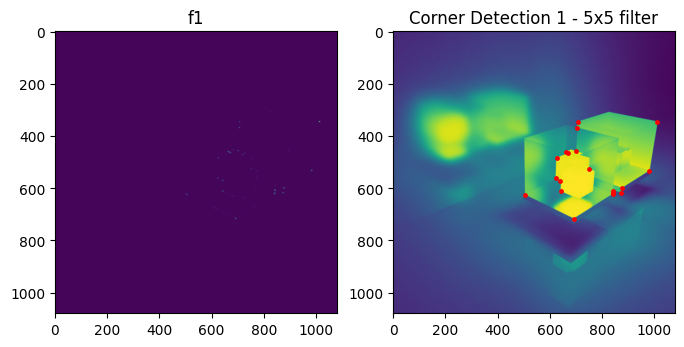

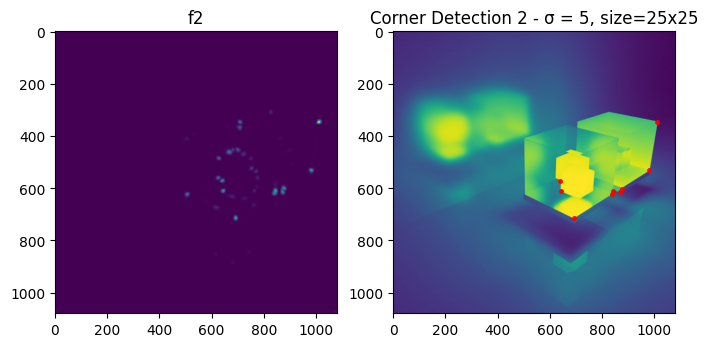

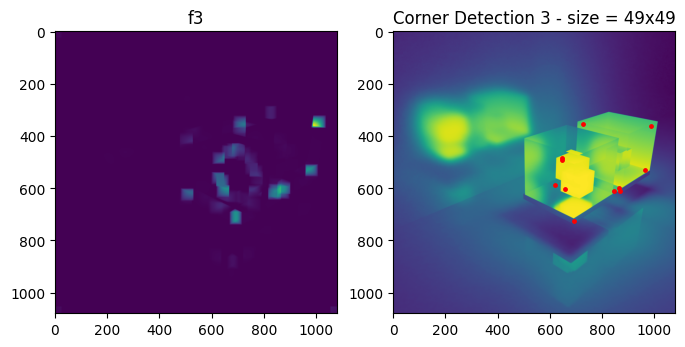

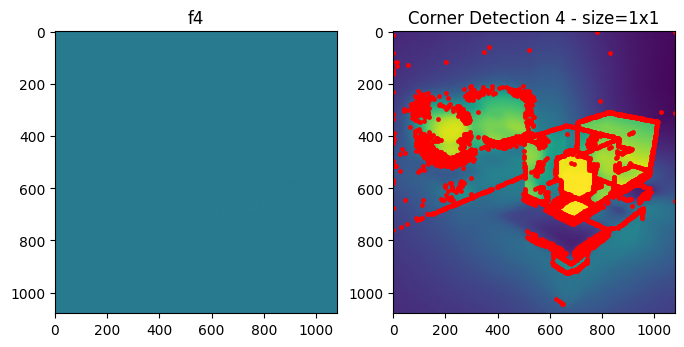

In [14]:
def get_gaussian_filter(n, sigma=1):
    assert(n % 2 == 1)
    h = (n + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Take the gaussian
    g = np.exp(-d_sq/2/(sigma**2))
    # Normalize
    g = g/g.sum().sum()
    return g

image = load_image("light_cubes_base.png")[:, :, 0]

#Horizontal Sobel Filter:
hf = [
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]
#Vertical Sobel Filter:
vf = [
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]

Ix = scipy.signal.convolve(
          image, hf, mode='same')
Iy = scipy.signal.convolve(
          image, vf, mode='same')



weight1 = np.ones((5, 5))/25
A = scipy.signal.convolve(Ix**2, weight1, mode='same')
B = scipy.signal.convolve(Ix * Iy, weight1, mode='same')
C = scipy.signal.convolve(Iy**2, weight1, mode='same')
f = (A*C-B**2) / (A+C+1E-30)

fig = plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.imshow(f)
plt.title("f1")
plt.subplot(1,2,2)
plt.imshow(image)

points = get_local_maxima(f, 0.1)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)
plt.title("Corner Detection 1 - 5x5 filter")
plt.show()

#================
weight2=get_gaussian_filter(25,5)
A = scipy.signal.convolve(Ix**2, weight2, mode='same')
B = scipy.signal.convolve(Ix * Iy, weight2, mode='same')
C = scipy.signal.convolve(Iy**2, weight2, mode='same')
f = (A*C-B**2) / (A+C+1E-30)

fig = plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.imshow(f)
plt.title("f2")
plt.subplot(1,2,2)
plt.imshow(image)

points = get_local_maxima(f, 0.1)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)
plt.title("Corner Detection 2 - σ = 5, size=25x25")

plt.show()

#===============================
weight3 = np.ones((49, 49))/(49**2)
A = scipy.signal.convolve(Ix**2, weight3, mode='same')
B = scipy.signal.convolve(Ix * Iy, weight3, mode='same')
C = scipy.signal.convolve(Iy**2, weight3, mode='same')
f = (A*C-B**2) / (A+C+1E-30)

fig = plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.imshow(f)
plt.title("f3")
plt.subplot(1,2,2)
plt.imshow(image)

points = get_local_maxima(f, 0.03)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)
plt.title("Corner Detection 3 - size = 49x49")

plt.show()


#===============================
weight4 = np.ones((1,1))/(1)
A = scipy.signal.convolve(Ix**2, weight4, mode='same')
B = scipy.signal.convolve(Ix * Iy, weight4, mode='same')
C = scipy.signal.convolve(Iy**2, weight4, mode='same')
f = (A*C-B**2) / (A+C+1E-30)

fig = plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.imshow(f)
plt.title("f4")
plt.subplot(1,2,2)
plt.imshow(image)

points = get_local_maxima(f, 1e-19)
for point in points:
    plt.scatter(point[0], point[1], color='red', s = 6)
plt.title("Corner Detection 4 - size=1x1")

plt.show()





## P2.2 Multi-scale Blob Detection

Here, we will be building on the in-class breakout session to experiment with using the (normalized) Laplacian of Gaussian (LoG) filter to detect "blobs" in an image and their scale.

### P2.2.1 Scale-Normalized Filter Response

In this question, I have provided you with a simple "circle image", in which a filled circle is placed at the center of a square image. Here, you know that the circle is the feature you are trying to detect and that its location is at the center, so the feature does not need to be *located*. Instead, you are asked to **find the radius of the circle** (the "blob feature" of interest). I showed some very-related plots in class, so your results should look quite similar to those.

The steps are detailed below:
1. **TASK** First, you will need to define the LoG filter function `get_LoG_filter(kernel_size, sigma)` using either the in-class notes or [this resource](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm). *Do not forget to implement the "scale normalized" version; otherwise you will have an incorrect circle radius. Consult the notes from class for this.*
2. **PLOTS (IMAGES REQUIRED)** Once you have computed the normalized LoG filter, apply it at multiple scales to the sample circle image I have provided you with and **plot a few of the filtered images**.  (Remember to make your kernel size big enough compared to your kernel's $\sigma$ so that it is not cut off at the edges.)
3. **PLOTS (GRAPH REQUIRED)** Plot "filter response" (the value of the image after the filter is applied) at the center of the circle versus $\sigma$. Confirm that the peak of the filter response at the center of the circle occurs at the $\sigma$ we expect. (Recall that the peak $\sigma$ value does not correspond to the radius of the circle).

**QUESTION A:** (1 sentence)
What is the relationship between the peak $\sigma$ and the circle's radius? 

**Note:** If you use the *unnormalized Laplace of Gaussian Filter*, the maximal feature response will not occur where you expect. Be sure to use the correct filter function.

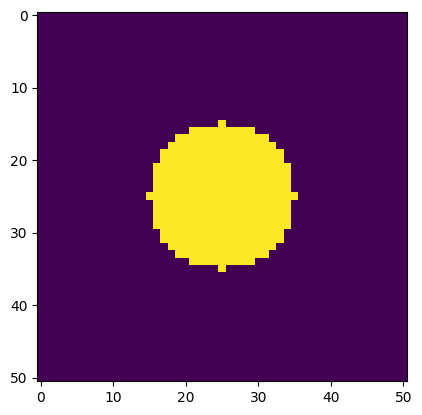

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def get_circ_image(image_size, radius):
    """Create an image of width `image_size` with a circle 
    of radius `radius` in its center."""
    assert(image_size % 2 == 1)
    h = (image_size + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Threshold by squared radius
    d_sq = (d_sq <= radius**2).astype(float)
    return d_sq

def get_LoG_filter(kernel_size, sigma):
    raise NotImplementedError("Your task is to implement the LoG filter.")

def apply_filter(signal, filt):
    """Apply a filter to an image; wrapper around scipy."""
    return scipy.signal.convolve2d(signal, filt, mode='same')

im_half_size = 25
fig = plt.figure()
circ_img = get_circ_image(2 * im_half_size + 1, radius=10)
plt.imshow(circ_img)

None

###  P2.2.2 Annotating an Image with Multi-Scale Detections

Now, let's assume that we have an image with multiple features and we don't know either where they are or what their "radius" or "scale" is. Your goal here is to simultaneously detect features and estimate their characteristic scale.

For testing purposes, I have provided you with a simple image with two circles in it. Your task is to automatically identify where these "blobs" are and what their radius is. By the time you're done, you should be able to automatically detect the feature locations *and* their scale, producing images like the following: 

<img src="auto_feature_detection_result.png" width="400">

Similar to the Harris Features from the last exercise, the features occur at extrema (both maxima and minima) in image-space. **Before we compute multi-scale features, pick 3 or 4 values of $\sigma$ and for each, plot the following:**
1. **PLOTS (GRAPH REQUIRED)** The filter response (applying the scaled LoG filter for a particular $\sigma$ to the image function) and;
2. **PLOTS (IMAGE REQUIRED)** The location of the extrema plotted on top of the original image (just like the Harris Corner exercise from the previous programming assignment). To compute the corners, you may use the `get_local_maxima_3D` function I have provided below (the same as from the last question, yet for 3D data to include sigma).

Now, we can put everything together. The multi-scale features we care about exist at extrema in both image space *and* in scale space. This will require computing the "blob" feature response in both image-space and in scale space (by iterating through different sigma values). Features will exist at extrema of $f$ in both image space and scale space. Your code for multi-scale blob detection (`compute_multi_scale_features`) will look something like the following:

```python
response = np.zeros(
    [image.shape[0], image.shape[1], sigmas.size]
)
for ii, sigma in enumerate(sigmas):
   filt = get_LoG_filter(kernel_size, sigma)
   feature_response = apply_filter_to_image(image, filt)
   # Store the absolute value (both large positive 
   # and negative responses correspond to features).
   response[:, :, ii] = np.abs(feature_response)
   
features = get_local_maxima_3D(response)
```

*Note: you can tune the threshold if you like. If the threshold is lower than mine, you will also detect some "blobs" in the dark space surrounding the bright circles. Both answers are acceptable for full credit.*

**PLOTS** Once you have computed the features, plot them as circles of the appropriate radius on top of three images: (1) the two-circle "test" image I have provided, (2) the "sunflower_field.jpg" image I have provided in this folder, and (3) a third image of your choosing.

[This resource](https://www.delftstack.com/howto/matplotlib/how-to-plot-a-circle-in-matplotlib/#matplotlib-patches-circle-method-to-plot-a-circle-in-matplotlib) will help you in drawing circles in matplotlib, but you can complete the function I have provided below if you prefer.

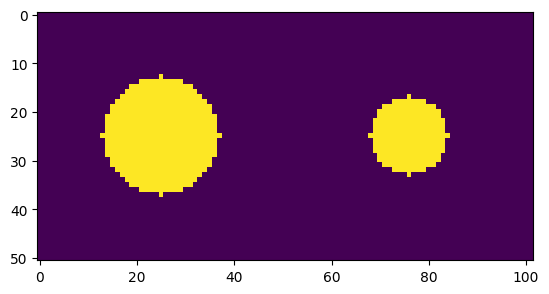

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage


def plot_circ_features(image, features, ax):
    ax.imshow(image, cmap='gray')
    for m in features:
        # if m[2] == sigmas.max():
        #     continue
        radius = None
        if radius is None:
            raise NotImplementedError()
        cir = plt.Circle((m[0], m[1]), radius, color='r', fill=False)
        ax.add_artist(cir)
        
def get_local_maxima_3D(data, threshold, sigmas, neighborhood_size=5):
    # See: https://stackoverflow.com/a/9113227/3672986
    data_region_max = scipy.ndimage.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = scipy.ndimage.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)

    features = []
    x, y = [], []
    for dy, dx, dz in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        y_center = int(round((dy.start + dy.stop - 1)/2))
        z_center = int(round((dz.start + dz.stop - 1)/2))
        features.append((x_center, y_center, sigmas[z_center]))
        
    return features
    
def compute_multi_scale_features(image, sigmas, threshold, window_size=11):
    raise NotImplementedError()

fig = plt.figure()
sigmas = np.arange(2, 20, 0.1)
circ_img_a = get_circ_image(2 * im_half_size + 1, radius=12)
circ_img_b = get_circ_image(2 * im_half_size + 1, radius=8)
circ_img = np.concatenate([circ_img_a, circ_img_b], axis=1)
plt.imshow(circ_img)

None

In [9]:
# Plotting

# Show for the circle image
image_base = circ_img
sigmas = np.arange(1.0, 10.0, 0.2)
features = compute_multi_scale_features(image_base, sigmas, 1.2)
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_circ_features(image_base, features, plt.gca())

# Feature response as a function of sigma
# Sunflower Image from: https://local12.com/news/local/deerfield-township-sunflower-field-attracts-shutterbugs
image_base = load_image("sunflower_field.jpg")[:, :, 0]
sigmas = np.arange(4.0, 80.0, 1.0)
features = compute_multi_scale_features(image_base, sigmas, 0.8)
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_circ_features(image_base, features, plt.gca())

# Feature response as a function of sigma 
# (you may replace with an image you chose)
image_base = load_image("light_cubes_base.png")[:, :, 0]
sigmas = np.arange(4.0, 80.0, 1.0)
features = compute_multi_scale_features(image_base, sigmas, 0.4)
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_circ_features(image_base, features, plt.gca())

NotImplementedError: 

## P2.3 Image Warping

In this question, we will pick up where we left off from the in-class breakout session. You are tasked with writing a `transform_image` function that takes as input an `image` and `transformation_matrix`. The function takes in an image and transforms it according to the `transformation_matrix`.

Using the `upsample_image` function I have provided below, write a new function `transform_image` that applies a transformation matrix to an image. You should feel free to use `scipy` for interpolation, **but you may not use `scipy` for anything other than the convolution, peak detection, and interpolation**.

> Note: you will notice in the comments in the provided function that there is a convention difference you need to keep track of: the `image` is stored in (row, column) coordinates, which is different from the transformation matrix, typically stored in (x, y) coordinates.

**PLOTS AND DESCRIPTIONS** Your goal, once this function is written, is to **implement the following transformation kernels, apply them to an image of your choosing, plot the image, and describe any surprising behavior of the kernels.** For the matrices I do not write out, be sure to include the transformation matrices in your writeup.:

1. The identity: $$\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix}$$
2. A rotation by 30 degrees
3. A rotation by 30 degrees and translated to the center (you don't have to compute the center exactly; just pick some parameters that translate the image so that it is roughly centered even after rotation)
4. Scale by a factor of 2 along the x-axis
5. This kernel (which you should describe): $$\begin{bmatrix} 1 & -1 & 0 \\ 1 & 1 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix}$$

Finally, experiment with homography transforms, by modifying the bottom row of the transformation matrix. Define two different homography transforms, write out their matrices and display the results. Hint: *You can show how this works on the image I have given you, but you might find it easier to understand what's going on with another simpler image: `image_base = np.zeros_like(image_base); image_base[64:-64, 64:-64] = 1`

**QUESTION:**
How do the two "bottom row" parameters control how the image is warped?

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import scipy.signal
from PIL import Image

def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]


def upsample_image(image, target_shape, interp_fn):
    """This function is from P1 and is here to give you an idea 
    of what your 'transform_image' should look like."""
    # Initialize the upsampled image
    image_up = np.zeros(target_shape)
    
    # Define the new coordinates (using the [y, x] convention
    # since image matrices are defined [row, column])
    new_xs = np.linspace(0, image.shape[1]-1, 
                         target_shape[1], endpoint=True)
    new_ys = np.linspace(0, image.shape[0]-1, 
                         target_shape[0], endpoint=True)
    
    # Loop through coordinates and set the image values
    for ix, new_x in np.ndenumerate(new_xs):
        for iy, new_y in np.ndenumerate(new_ys):
            image_up[iy, ix] = interp_fn(image, new_x, new_y)
            
    return image_up


def transform_image(image, transformation_matrix):
    # Notice that because matrices are stored "rows, columns",
    # we need to flip the "shape" coordinates so that the transformation
    # matrix does what we expect. The other convention is also acceptable,
    # as long as one is consistent. In this function, the transformation
    # matrix is assumed to be in [x, y, w] coordinates, even though the image
    # is stored in row, column (y, x) coordinates.
    sh = image.shape
    x = np.arange(image.shape[1]).astype(float)
    y = np.arange(image.shape[0]).astype(float)
    
    # For now, the dimensions of the output image will
    # remain unchanged. You could modify xi and yi to 
    # change the domain of the output image.
    xi = np.arange(image.shape[1]).astype(float)
    yi = np.arange(image.shape[0]).astype(float)

    # Perform the transformation
    image_fn = RectBivariateSpline(x, y, image.T)  # Transpose needed for proper x, y coordinate
    
    # Note: you can use this 'image_fn' to perform interpolation instead
    # of your implementation: new_val = image_fn(new_x, new_y)[0, 0]
    transformed_image = np.zeros((len(yi), len(xi)))
    # TODO: Loop through all pixels in new 'transformed_image' and set their values
    raise NotImplementedError()
    return transformed_image


## P2.4 Some Simple Feature Descriptors

In class you learned about some different strategies for describing features; now we're going to implement them and see how well they perform under different image transformations. Here are the relevant slides from class for the four different descriptors you will be implementing for this problem (exact vector comparison, an x-gradient binary descriptor, a color/brightness histogram, a spatial histogram):

<img src="descriptors_overview.png" width="600">

Compute some of the simple image descriptors we discussed in class  and see how effective they are at matching features across different image transformations. To locate the features, use your Harris Corner detector from question P2.1. I have provided code that computes the feature descriptors for small image patches surrounding each of your features using three of these strategies. I have also included code under `Descriptor Matching Plotting Code` that plots the matches for a set of test images.

**TASK** Implement the `get_corners` function (in the code block named `Computing and Matching Descriptors` using your Harris Corner detection solution from P2.1. If that function is implemented properly, you should be able to generate plots showing match quality.

**FIGURES** Once you have implemented `get_corners` the code below should generate plots for the three different descriptors. Include all three in your writeup.

**QUESTION A** Which feature descriptor performs poorly on the image `img_contrast`? Explain why this descriptor performs worse than the others.

**QUESTION B** Which feature descriptor performs best on the image `img_transpose`? Explain why this descriptor performs better than the others.

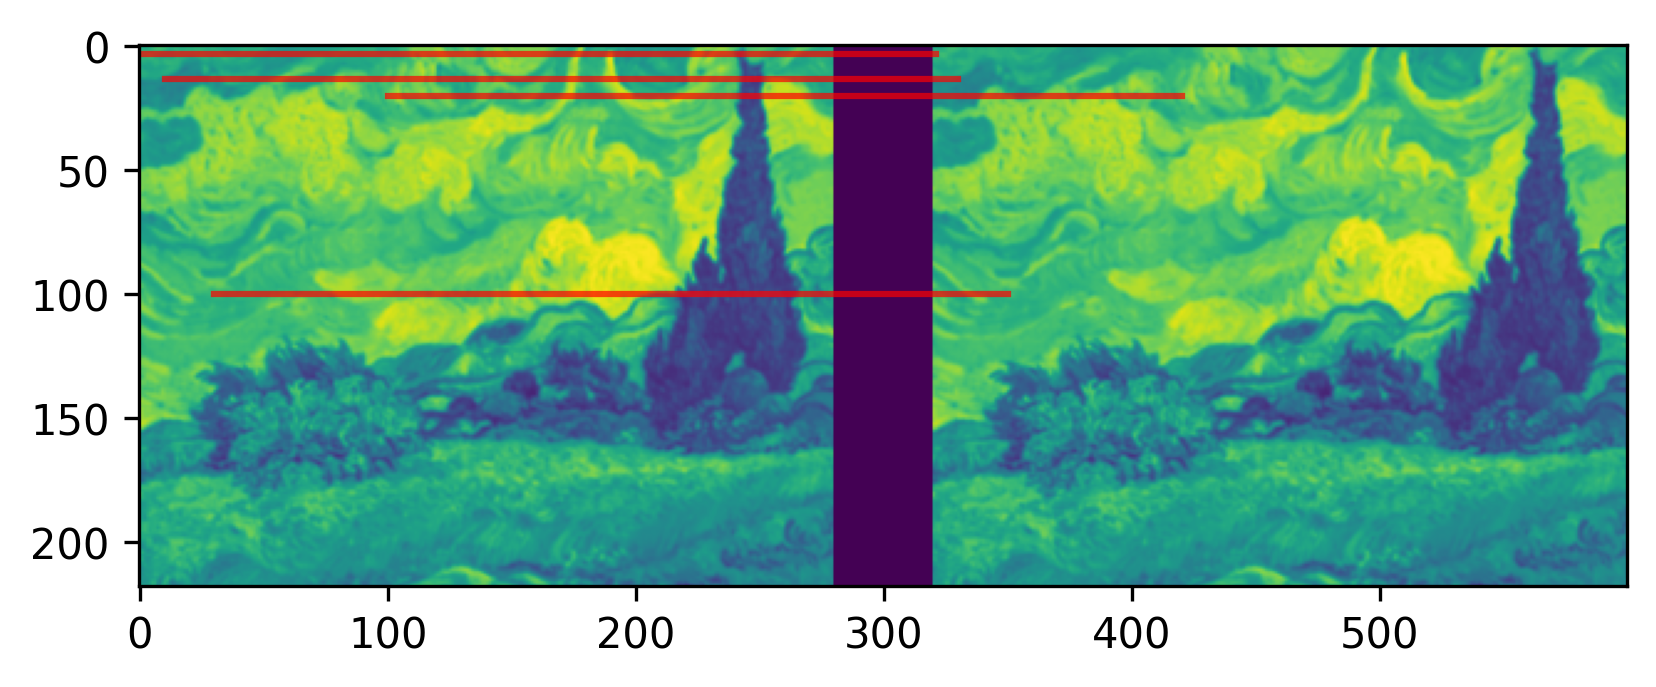

In [ ]:
## Helper code for plotting
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.signal
from PIL import Image

def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

def visualize_matches(img_a, img_b, matches, ax=None, title=None):
    """Visualize matches between two images. Matches is a list
    such that each element of the list is a 4-element tuple of
    the form [x1, y1, x2, y2]."""
    if ax is None:
        # Create a new axis if none is provided
        fig = plt.figure(dpi=300)
        ax = plt.gca()
    
    # Helper variables
    sa = img_a.shape
    sb = img_b.shape
    sp = 40
    
    # Merge the images and plot matches
    merged_imgs = np.zeros(
        (max(sa[0], sb[0]), sa[1]+sb[1]+sp),
        dtype=float)
    merged_imgs[0:sa[0], 0:sa[1]] = img_a
    merged_imgs[0:sb[0], sa[1]+sp:] = img_b
    ax.imshow(merged_imgs)
    
    for m in matches:
        ax.plot([m[0], m[2]+sa[1]+sp], 
                [m[1], m[3]],
                'r', alpha=0.7)
    
    if title is not None:
        ax.set_title(title)

# An example of match visualization
# Stored: [x1, y1, x2, y2]
img_base = load_image('tr_base.png')[:, :, 0]
matches = [
    [1, 3, 1, 3],
    [10, 13, 10, 13],
    [100, 20, 100, 20],
    [30, 100, 30, 100]
]
visualize_matches(img_base, img_base, matches)

In [ ]:
## Computing and Matching Descriptors

# Compute images for matching
img_base = load_image('light_cubes_sm.png')[:, :, 0]
img_contrast = img_base ** (0.4)
img_highres = load_image('light_cubes_base.png')[300:300+img_base.shape[0],
                                                 400:400+img_base.shape[1], 0]
img_transpose = img_base.T


# TASK: you need to implement Harris Corner Detection
# Set the default 'threshold' to your satisfaction.
def get_corners(image, threshold=0.01):
    """Note: this function assumed to return corners 
    as (x, y) coordinates *not* as (row, column) 
    coordinates."""
    raise NotImplementedError()

def get_features_with_descriptors(image,
                                  corners,
                                  compute_descriptor_fn, 
                                  patch_half_width=7):
    features = []
    for c in corners:
        patch = image[c[1]-patch_half_width:c[1]+patch_half_width+1,
                      c[0]-patch_half_width:c[0]+patch_half_width+1]
        
        # Remove patches too close to the edge
        if patch.size < (2*patch_half_width + 1) ** 2:
            continue
        features.append({
            'x': c[0],
            'y': c[1],
            'patch': patch,
            'descriptor': compute_descriptor_fn(patch),
        })
    
    return features


# Define the various descriptors

def compute_descriptor_match(patch):
    return (patch - np.mean(patch)) / np.std(patch)

def compute_descriptor_binary_x(patch):
    return 2 * ((patch[:-1] - patch[1:]) > 0).astype(float) - 1

def compute_descriptor_hist(patch):
    return np.sqrt(np.histogram(patch, bins=8, range=(0.0, 1.0))[0])


# Define the matching functions

def compare_descriptors(fa, fb):
    return np.sum(fa['descriptor'] * fb['descriptor'])

def compute_feature_matches(fsa, fsb):
    # First compute the strength of the feature response
    sims = np.zeros((len(fsa), len(fsb)), dtype=float)
    for ii, fa in enumerate(fsa):
        for jj, fb in enumerate(fsb):
            sims[ii, jj] = compare_descriptors(fa, fb)

    # Now compute the matches
    matches = []
    for ii in range(len(fsa)):
        mi = np.argmax(sims[ii])
        if not ii == np.argmax(sims[:, mi]):
            continue
        match_score = sims[ii, mi]
        matches.append([fsa[ii]['x'],
                        fsa[ii]['y'],
                        fsb[mi]['x'],
                        fsb[mi]['y']])

    return matches

In [ ]:
# Descriptor Matching Plotting Code
for (fn, title) in [(compute_descriptor_match, "Match"),
        (compute_descriptor_binary_x, "Binary (x)"),
        (compute_descriptor_hist, "Histogram")]:
    plt.figure(figsize=(12, 6))
    
    corners = get_corners(img_base)
    fsa = get_features_with_descriptors(img_base, corners, fn)
    
    for ind, image_comp in enumerate(
            [img_base, img_contrast, img_highres, img_transpose]):
    
        ax = plt.subplot(2, 2, ind+1)
        corners = get_corners(image_comp)
        fsb = get_features_with_descriptors(image_comp, corners, fn)
        matches = compute_feature_matches(fsa, fsb)
        visualize_matches(img_base, image_comp, matches, ax, title)

NotImplementedError: 

<Figure size 1200x600 with 0 Axes>